In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import numba
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, euclidean

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs

from xrun.data.run_info import RunInfo
from xrun.data.loader import load_dataset
from sklearn.cluster import KMeans

from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from scipy.sparse import linalg as sparse_linalg, issparse
from sklearn.utils import shuffle
from sklearn.utils.extmath import safe_sparse_dot

In [3]:
def geometric_median(X, eps=1e-5):
    # https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [4]:
centers = np.random.randint(low=2, high=10)
raw_data, _ = make_blobs(n_samples=2000, centers=centers)

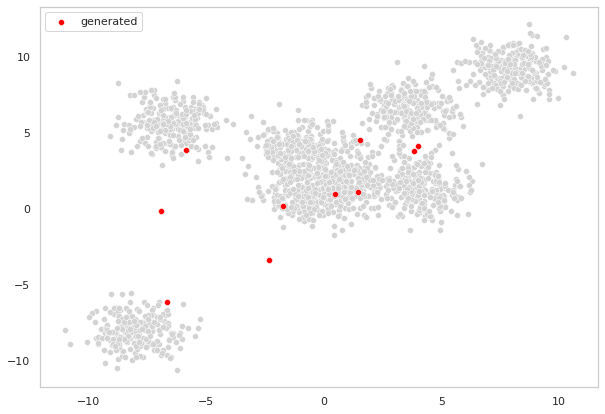

In [5]:

n_points = raw_data.shape[0]
indices = np.arange(start=0, stop=n_points)
generated_points = []
for i in range(10):
    n_points = raw_data.shape[0]
    new_size = 2 # n_points# 5 # int(n_points * 0.02)
    random_vector = np.random.rand(new_size, 1)
    proba_vector = random_vector / random_vector.sum()
    
    random_selection = np.random.choice(indices, new_size)
    new_point = np.dot(proba_vector.T, raw_data[random_selection])
    generated_points.append(new_point)

generated_points = np.array(generated_points).squeeze()

#proba_vector
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", ax=ax)
sns.scatterplot(x=generated_points[:,0], y=generated_points[:,1], color='red', label="generated", ax=ax)
# ax.set_ylim([-15, 15])
# ax.set_ylim([-15, 15])
ax.grid(False)

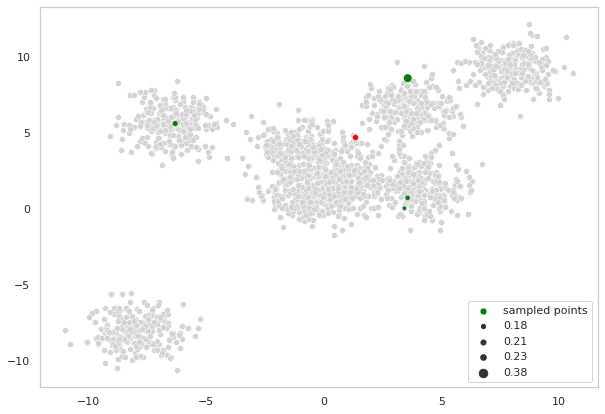

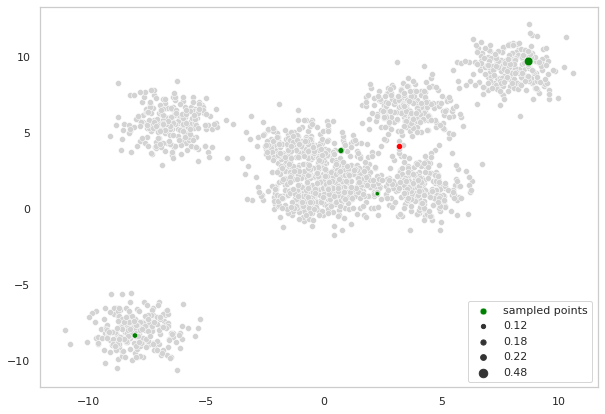

In [6]:

for i in range(2):
    n_points = raw_data.shape[0]
    new_size = 4 # int(n_points * 0.02)
    random_vector = np.random.rand(new_size, 1)
    proba_vector = random_vector / random_vector.sum()
    
    random_selection = np.random.choice(indices, new_size)
    new_point = np.dot(proba_vector.T, raw_data[random_selection])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", ax=ax)
    sns.scatterplot(x=new_point[:,0], y=new_point[:,1], color='red', ax=ax)
    sns.scatterplot(x=raw_data[random_selection][:,0], y=raw_data[random_selection][:,1], 
                    size=proba_vector.round(2).squeeze(), color='green', label="sampled points", ax=ax)
    ax.grid(False)

## k-Means

In [7]:
k = 10
km = KMeans(n_clusters=k*2, n_init=10, max_iter=1)
km.fit(raw_data)
cluster_centers = km.cluster_centers_

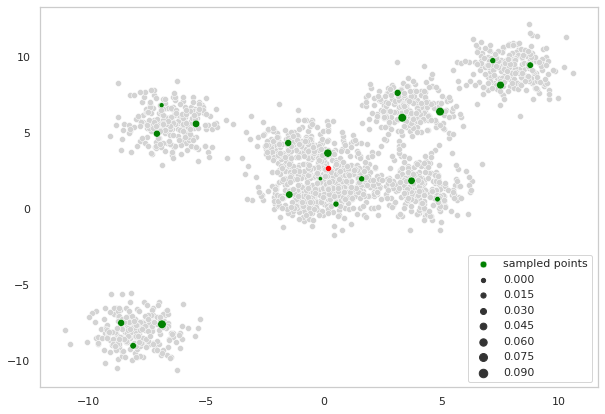

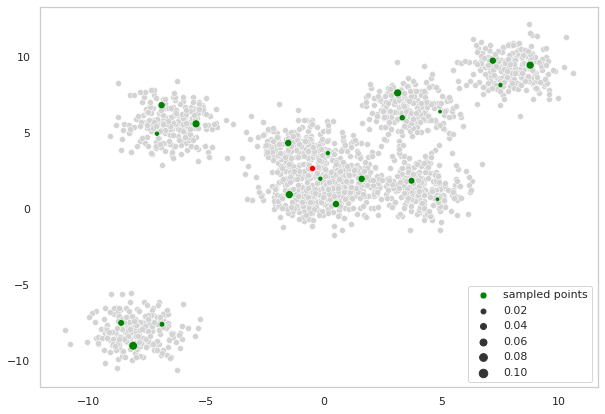

In [8]:

for i in range(2):
    n_points = raw_data.shape[0]
    new_size = cluster_centers.shape[0]
    random_vector = np.random.rand(new_size, 1)
    proba_vector = random_vector / random_vector.sum()
    
    random_selection = np.random.choice(indices, new_size)
    new_point = np.dot(proba_vector.T, cluster_centers)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", ax=ax)
    sns.scatterplot(x=new_point[:,0], y=new_point[:,1], color='red', ax=ax)
    sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:,1], 
                    size=proba_vector.round(2).squeeze(), color='green', label="sampled points", ax=ax)
    ax.grid(False)

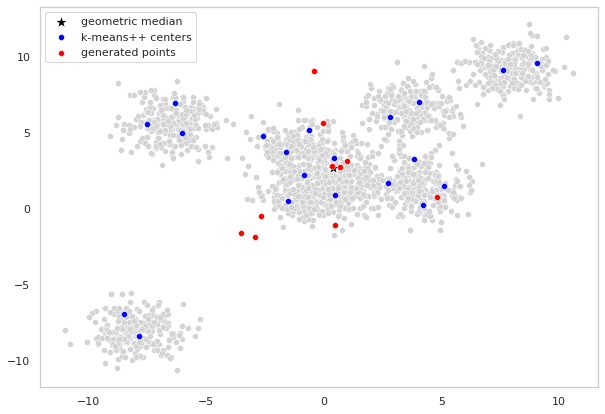

In [9]:
k = 10
km = KMeans(n_clusters=k*2, n_init=1, max_iter=1)
km.fit(raw_data)

cluster_centers = km.cluster_centers_

gm = geometric_median(raw_data)


n_points = raw_data.shape[0]
indices = np.arange(start=0, stop=n_points)
generated_points = []
for i in range(10):
    n_points = raw_data.shape[0]
    new_size = cluster_centers.shape[0]
    random_vector = np.random.rand(new_size, 1)
    proba_vector = random_vector / random_vector.sum()
    
    random_selection = np.random.choice(indices, new_size)
    new_point = np.dot(proba_vector.T, cluster_centers)

    generated_points.append(new_point)

generated_points = np.array(generated_points).squeeze()

generated_points = generated_points * 5
generated_points = generated_points - geometric_median(generated_points) + gm

#proba_vector
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", ax=ax)
sns.scatterplot(x=[gm[0]], y=[gm[1]], label="geometric median", marker="*", color="black", s=200, ax=ax)
sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:,1], color='blue', label="k-means++ centers", ax=ax)
sns.scatterplot(x=generated_points[:,0], y=generated_points[:,1], color='red', label="generated points", ax=ax)
# ax.set_ylim([-15, 15])
# ax.set_ylim([-15, 15])
ax.grid(False)